# Experimentation and Uplift Testing

### The content follows the above order:
1. Define metrics to select control stores.
2. Analyze trial stores against controls.
3. Data analysis and visualization and summarise findings and provide recommendations.

## Load Data

In [1]:
#import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t
import seaborn as sns

In [4]:
data = pd.read_csv("QVI_data.csv")

In [5]:
## Create YearMonth ID
data['YearMonth'] = pd.Series(data['DATE'].str[0:7].str.replace('-',''))
data[["YearMonth"]] = data[["YearMonth"]].astype('int')


## Define Metrics

In [7]:
#For each store and month calculate total sales, number of customers, 
# transactions per customer, chips per customer and the average price per unit.
def monthly_measure_metric():
    measureOverTime = data.groupby(["STORE_NBR", "YearMonth"]).agg(
        totSales = ("TOT_SALES", np.sum),
        nCustomers = ("LYLTY_CARD_NBR", lambda x: x.nunique()),
        nTxn = ("TXN_ID", lambda x: x.nunique()),
        totProd = ("PROD_QTY", np.sum)
    )

    measureOverTime = measureOverTime.assign(nTxnPerCust = measureOverTime['nTxn'] / measureOverTime['nCustomers'],
                        nChipsPerTxn = measureOverTime['totProd']/measureOverTime['nTxn'],
                         avgPricePerUnit = measureOverTime['totSales']/measureOverTime['totProd'] ).drop(columns = ["nTxn", "totProd"])


    measureOverTime = measureOverTime.reset_index().sort_values(by = ['STORE_NBR','YearMonth'])
    return measureOverTime



In [250]:
#### Filter to the pre‐trial period and stores with full observation periods
qvi_metric = monthly_measure_metric()
qvi_metric.info()
result1 = qvi_metric['STORE_NBR'].value_counts()


storesWithFullObs = result1[result1==12].index.unique().tolist()
full_observ = qvi_metric[qvi_metric['STORE_NBR'].isin(storesWithFullObs)]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3169 non-null   int64  
 1   YearMonth        3169 non-null   int64  
 2   totSales         3169 non-null   float64
 3   nCustomers       3169 non-null   int64  
 4   nTxnPerCust      3169 non-null   float64
 5   nChipsPerTxn     3169 non-null   float64
 6   avgPricePerUnit  3169 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 198.1 KB


In [294]:
preTrial_full_observ = full_observ.loc[(full_observ['YearMonth']< 201903)]
preTrial_full_observ.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 3164
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        2080 non-null   int64  
 1   YearMonth        2080 non-null   int64  
 2   totSales         2080 non-null   float64
 3   nCustomers       2080 non-null   int64  
 4   nTxnPerCust      2080 non-null   float64
 5   nChipsPerTxn     2080 non-null   float64
 6   avgPricePerUnit  2080 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 130.0 KB


In [11]:
def calculateCorrelation(metricCol, storeComparison, inputTable = preTrial_full_observ):
    
    control_store_nbrs = inputTable[~inputTable['STORE_NBR'].isin([77, 86,88])]['STORE_NBR'].unique()
    trial_store = inputTable[inputTable['STORE_NBR'] == storeComparison][metricCol].reset_index()
    dists = pd.DataFrame(columns = [ "YearMonth","Control_store", "Trial_store", "Corr_measure"])

    
    for i in control_store_nbrs:
        
        concat_df = pd.DataFrame(columns = [ "YearMonth","Control_store", "Trial_store", "Corr_measure"])
        control_store = inputTable[inputTable['STORE_NBR'] == i][metricCol].reset_index()


        concat_df['YearMonth'] = list(inputTable[inputTable['STORE_NBR'] == storeComparison]["YearMonth"])
        concat_df['Control_store'] = i
        concat_df['Trial_store'] = storeComparison
        concat_df['Corr_measure'] = control_store.corrwith(trial_store, axis = 1)
    
        dists = pd.concat([dists, concat_df])
        
    return dists


In [251]:
# e a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.

def calculateMagnitudeDistance(metricCol, storeComparison, inputTable = preTrial_full_observ):
    
    control_store_nbrs = inputTable[~inputTable['STORE_NBR'].isin([77, 86,88])]['STORE_NBR'].unique()
    trial_store = inputTable[inputTable['STORE_NBR'] == storeComparison][metricCol].reset_index()
    dists = pd.DataFrame()
    
    
    for i in control_store_nbrs:
        concat_df = abs(inputTable[inputTable['STORE_NBR'] == storeComparison].reset_index()[metricCol] - 
                           inputTable[inputTable['STORE_NBR'] == i].reset_index()[metricCol])
        concat_df['Trial_store'] = storeComparison
        concat_df['Control_store']= i
        concat_df['YearMonth']= list(inputTable[inputTable['STORE_NBR'] == storeComparison]["YearMonth"])

        
        dists = pd.concat([dists, concat_df])
        
 #min-max scale       
    for col in metricCol: 
        dists[col] = 1 - ((dists[col]-dists[col].min())/(dists[col].max() - dists[col].min()))
        
    dists['magnititude'] = dists[metricCol].mean(axis = 1 )
    return dists

metricCol = ['nTxnPerCust']
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculateMagnitudeDistance(metricCol, trial_num)])
    




## Combine Correlation and Magnititude 

In [13]:
def combine_corr_dist(corr_weight, metricCol, storeComparison,inputTable = preTrial_full_observ):
    
    corrs = calculateCorrelation(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison,inputTable).drop(metricCol, axis = 1)
    
    combine = pd.merge(corrs, dists, on =["YearMonth", "Control_store", "Trial_store"])
    combine['scoreNCust'] = combine["Corr_measure"] * corr_weight + combine["magnititude"] * (1-corr_weight)
    
    return combine
    


In [14]:
# def get_control_store(metricCol):
#     trail_store = [77, 86, 88]
#     combine_table = pd.DataFrame()

#     for trial_num in trial_store:
#         combine_tables = combine_corr_dist(0.5, metricCol, trial_num, inputTable = preTrial_full_observ)
#         combine_table = pd.concat([combine_table, combine_tables])
    
    
#     data = combine_tables.groupby(['Control_store','Trial_store'])['scoreNCust'].mean().reset_index()
#     orderr = data.sort_values('scoreNCust',ascending=False).groupby('Trial_store').head(3).sort_values(['Trial_store', 'scoreNCust'])
    
#     return orderr

        
# get_control_store(['totSales'])

In [15]:
trail_store = [77, 86, 88]
combine_table = pd.DataFrame()

for trial_num in trail_store:
    combine_tables = combine_corr_dist(0.5, ["totSales"], trial_num, inputTable = preTrial_full_observ)
    combine_table = pd.concat([combine_table, combine_tables])


d = combine_table.groupby(['Control_store','Trial_store'])['scoreNCust'].mean().reset_index()
d.sort_values('scoreNCust',ascending=False).groupby('Trial_store').head(3).sort_values(['Trial_store', 'scoreNCust'], ascending=False)


,Control_store,Trial_store,scoreNCust
113,40,88,0.973604
206,72,88,0.946832
74,26,88,0.945747
433,155,86,0.983630
298,109,86,0.981858
631,225,86,0.974118
654,233,77,0.993680
717,255,77,0.990156
126,46,77,0.988993


Trial store 88: 237, 203,40 <p>
Trial store 86: 155, 225,109<p>
Trial store 77: 233, 41, 111<p>


In [16]:
trail_store = [77, 86, 88]
combine_table = pd.DataFrame()

for trial_num in trail_store:
    combine_tables = combine_corr_dist(0.5, ["totSales"], trial_num, inputTable = preTrial_full_observ)
    combine_table = pd.concat([combine_table, combine_tables])


d = combine_table.groupby(['Control_store','Trial_store'])['scoreNCust'].mean().reset_index()
d.sort_values('scoreNCust',ascending=False).groupby('Trial_store').head(3).sort_values(['Trial_store', 'scoreNCust'], ascending=False)


,Control_store,Trial_store,scoreNCust
113,40,88,0.973604
206,72,88,0.946832
74,26,88,0.945747
433,155,86,0.983630
298,109,86,0.981858
631,225,86,0.974118
654,233,77,0.993680
717,255,77,0.990156
126,46,77,0.988993


Trial store 88: 40, 26,73<p>
Trial store 86: 109, 155,222<p>
Trial store 77: 233, 255, 188<p>


#### Overall conclusion: 
#### Trial store 77: Control Store 233
#### Trial store 86: Control Store 155
#### Trial store 88: Control Store 40

## Analyze Trial Stores Against Controls.

In [18]:
measure_Over_Time_Sales = monthly_measure_metric()
measure_Over_Time_Sales.head()

,STORE_NBR,YearMonth,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [19]:

# control_store = [233,155,40]
# trial_store = [88, 86, 77]

# measure_Over_Time_Sales["Store_type"] = 'Other'  # Default value for all rows
    
# for index, row in measure_Over_Time_Sales.iterrows():
#     if row['STORE_NBR'] in trail_store and row['YearMonth'] < 201902: 
#         measure_Over_Time_Sales.at[index, "Store_type"] = 'Trail'
        
#     elif row['STORE_NBR'] in control_store and row['YearMonth'] < 201902:
#         measure_Over_Time_Sales.at[index, "Store_type"] = 'Control'

        
    
    

In [20]:


control_store = [233,155,40]
trial_store = [88, 86, 77]

preTrial_full_observ["Store_type"] = 'Other'  # Default value for all rows
    
for index, row in preTrial_full_observ.iterrows():
    if row['STORE_NBR'] in trail_store: 
        preTrial_full_observ.at[index, "Store_type"] = 'Trail'
        
    elif row['STORE_NBR'] in control_store and row['YearMonth'] < 201902:
        preTrial_full_observ.at[index, "Store_type"] = 'Control'




/var/folders/qc/zvz1knc173n7lpbcfzncj0_h0000gn/T/ipykernel_22328/2664555081.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrial_full_observ["Store_type"] = 'Other'  # Default value for all rows


In [22]:
#trail_store = [77, 86, 88]
#control_store = [233,155,40]
#measure_Over_Time_Sales['Store_type'] = 'other'

#measure_Over_Time_Sales.loc[(measure_Over_Time_Sales['STORE_NBR'].isin(trail_store)) & (measure_Over_Time_Sales['YearMonth'] < 201902), "Store_type"] = 'Trial'

#measure_Over_Time_Sales.loc[(measure_Over_Time_Sales['STORE_NBR'].isin(control_store)) & (measure_Over_Time_Sales['YearMonth'] < 201902), "Store_type"] = 'Control'




In [23]:
preTrial_full_observ['Date'] = pd.to_datetime(preTrial_full_observ['YearMonth'], format = '%Y%m')

preTrial_full_observ.sort_values('YearMonth').head

/var/folders/qc/zvz1knc173n7lpbcfzncj0_h0000gn/T/ipykernel_22328/2522830502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrial_full_observ['Date'] = pd.to_datetime(preTrial_full_observ['YearMonth'], format = '%Y%m')


<bound method NDFrame.head of       STORE_NBR  YearMonth  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0             1     201807     206.9          49     1.061224      1.192308   
3013        260     201807     453.0          49     1.081633      2.000000   
1230        108     201807     242.7          30     1.000000      1.900000   
1218        107     201807     805.4          90     1.255556      2.035398   
1206        106     201807    1042.8         111     1.261261      2.057143   
...         ...        ...       ...         ...          ...           ...   
1812        156     201902     985.8         107     1.289720      2.014493   
1800        155     201902     891.2          95     1.315789      2.032000   
1788        154     201902    1021.8         107     1.130841      1.966942   
1764        152     201902     820.8          93     1.268817      2.016949   
3164        272     201902     395.5          45     1.066667      1.895833   

      avgPricePerUnit

In [24]:
Pretrail_sales = pd.DataFrame(preTrial_full_observ.groupby(['Date','STORE_NBR','Store_type'])['totSales'].mean()).reset_index()


In [25]:
trail_control_dict = {77:233, 86:155, 88:40}
trail_control_dict.items()

dict_items([(77, 233), (86, 155), (88, 40)])

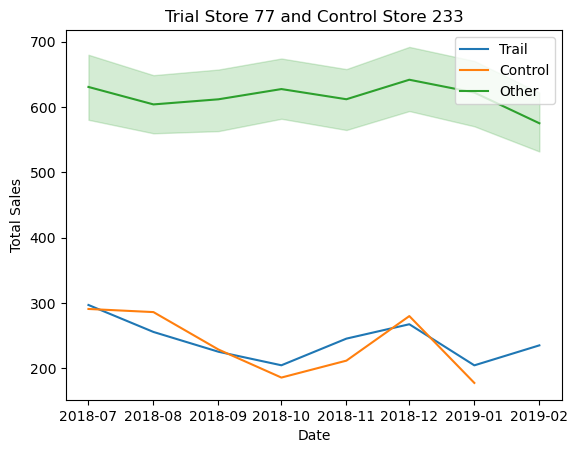

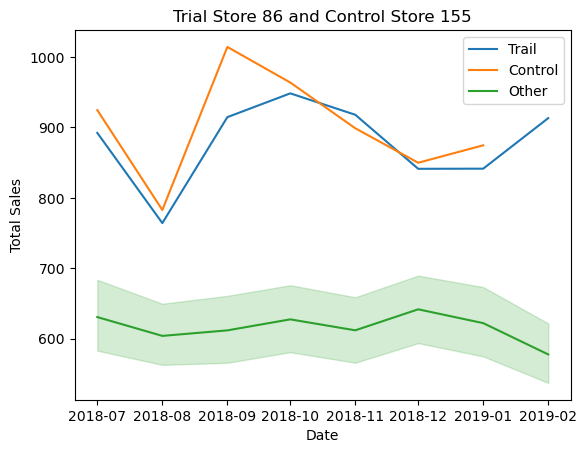

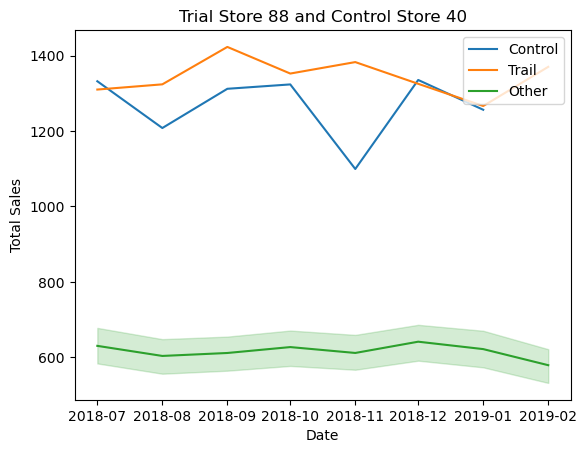

In [26]:

trial_control_dict = {77:233, 86:155, 88:40}
d_other = Pretrail_sales[Pretrail_sales['Store_type'] == 'Other']

for key, value in trial_control_dict.items(): 
    d_triCon = Pretrail_sales[Pretrail_sales['STORE_NBR'].isin([key, value])]
    pre_plt = pd.concat([d_triCon, d_other])
    plt.figure()  # Create a new figure for each plot
    sns.lineplot(
        x=pre_plt["Date"],
        y=pre_plt["totSales"],
        hue=pre_plt["Store_type"]
    )
    plt.title(f"Trial Store {key} and Control Store {value}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend(loc='upper right')  # Adjust the legend location as needed

plt.show()
   
 


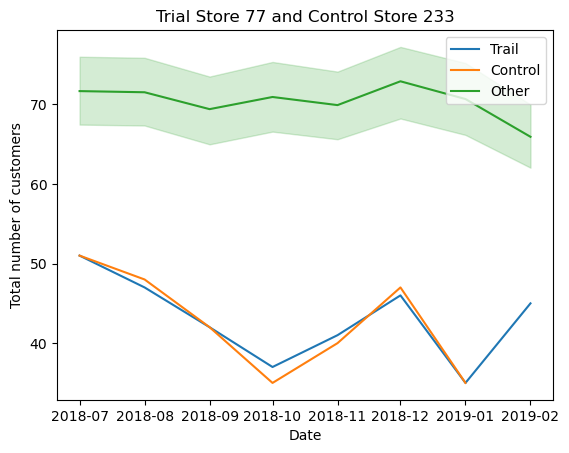

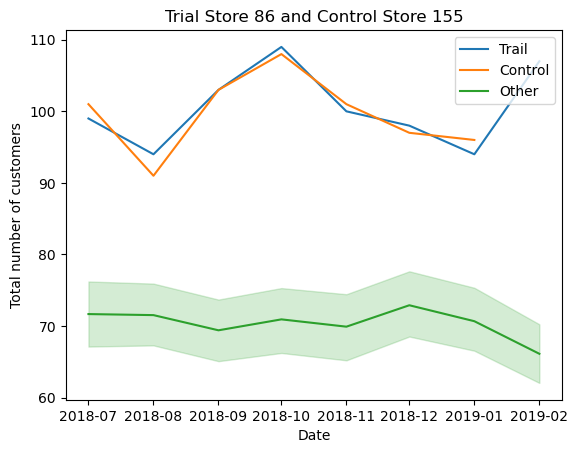

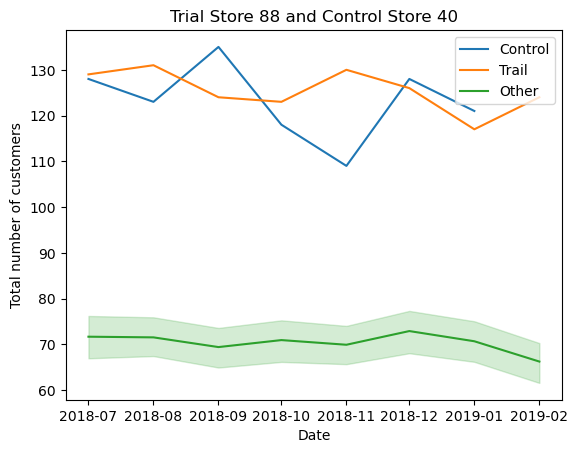

In [27]:
Pretrail_nCustomer = pd.DataFrame(preTrial_full_observ.groupby(['Date','STORE_NBR','Store_type'])['nCustomers'].mean()).reset_index()

trial_control_dict = {77:233, 86:155, 88:40}
d_other = Pretrail_nCustomer[Pretrail_nCustomer['Store_type'] == 'Other']

for key, value in trial_control_dict.items(): 
    d_triCon = Pretrail_nCustomer[Pretrail_nCustomer['STORE_NBR'].isin([key, value])]
    pre_plt = pd.concat([d_triCon, d_other])
    plt.figure()  # Create a new figure for each plot
    sns.lineplot(
        x=pre_plt["Date"],
        y=pre_plt["nCustomers"],
        hue=pre_plt["Store_type"]
    )
    plt.title(f"Trial Store {key} and Control Store {value}")
    plt.xlabel("Date")
    plt.ylabel("Total number of customers")
    plt.legend(loc='upper right')  # Adjust the legend location as needed

plt.show()



We could see from the above plots, from the trial period goes from the start of March 2019 to June 2019. 

### Total sales

In [306]:
#Scale pre‐trial control sales to match pre‐trial trial store sales
#control 77 and trail 233
sales_ratio_233 = (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 77]['totSales'].sum())/ (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 233]['totSales'].sum())

sales_ratio_155 = (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 86]['totSales'].sum())/ (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 155]['totSales'].sum())

sales_ratio_40 = (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 88]['totSales'].sum())/ (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 40]['totSales'].sum())

In [307]:
#full_observ
#preTrial_full_observ.head(3)
#trial_full_observ = full_observ[full_observ['YearMonth']>=201902 & full_observ['YearMonth']<=201904]


In [308]:


Control_Store_Sales_Scale = full_observ[full_observ['STORE_NBR'].isin([233, 155, 40])]



def scale_sales(row):
    if row['STORE_NBR'] == 233:
        return row['totSales'] * sales_ratio_233
    
    elif row['STORE_NBR'] == 155:
        return row['totSales'] * sales_ratio_155
    
    elif row['STORE_NBR'] == 40:
        return row['totSales'] * sales_ratio_40

Control_Store_Sales_Scale['Scale_Control_Sales'] = Control_Store_Sales_Scale.apply(lambda x: scale_sales(x), axis = 1)

/var/folders/qc/zvz1knc173n7lpbcfzncj0_h0000gn/T/ipykernel_22328/1142763284.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Control_Store_Sales_Scale['Scale_Control_Sales'] = Control_Store_Sales_Scale.apply(lambda x: scale_sales(x), axis = 1)


In [309]:
# percentage difference between scaled control sales and trial sales during trial period 201902-201904


In [310]:
trial_full_observ = full_observ[(full_observ['YearMonth']>=201902) & (full_observ['YearMonth']<=201904)]

trial_scale_control_observ = Control_Store_Sales_Scale[(Control_Store_Sales_Scale['YearMonth']<=201904) &
                                                      (Control_Store_Sales_Scale['YearMonth']>=201902)]
Pretrial_scale_control_observ = Control_Store_Sales_Scale[(Control_Store_Sales_Scale['YearMonth']<201902)]




In [311]:

percentage_diff = {}
trial_control_dict = {77:233, 86:155, 88:40}

trial_vs_control_trialperiod = pd.DataFrame()

for trail, control in trial_control_dict.items(): 
    c = trial_scale_control_observ[trial_scale_control_observ['STORE_NBR'] == control][['STORE_NBR', 'YearMonth', 'Scale_Control_Sales']]
    t = trial_full_observ[trial_full_observ['STORE_NBR'] == trail][['STORE_NBR', 'YearMonth','totSales']]
    percentage_diff[trail] = (t['totSales'].sum()-c['Scale_Control_Sales'].sum())/(c['Scale_Control_Sales'].sum())
    #a = c.merge(t, how = 'left', on ='YearMonth',suffixes=('_control', '_trial'))
    #a['percentage_diff'] = (a['totSales'].sum()-a['Scale_Control_Sales'].sum())
    #trial_vs_control_trialperiod = pd.concat([trial_vs_control_trialperiod,a])
print(percentage_diff) 

{77: 0.27117651315069186, 86: 0.12366996020517054, 88: 0.04968770321884413}


In [312]:
scaled_trial_vs_control = pd.DataFrame()
for trail, control in trial_control_dict.items(): 
    temp1 = Control_Store_Sales_Scale[Control_Store_Sales_Scale['STORE_NBR'] == control][['STORE_NBR', 'YearMonth', 'Scale_Control_Sales']]
    temp2 = full_observ[full_observ['STORE_NBR'] == trail][['STORE_NBR', 'YearMonth', 'totSales']]

    aa = temp1.merge(temp2, how = 'left', on = 'YearMonth', suffixes=('_control', '_trial'))
    scaled_trial_vs_control = pd.concat([scaled_trial_vs_control, aa])
    
    
scaled_trial_vs_control['STORE_NBR_trial'].unique()

array([77, 86, 88])

In [313]:
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else :
        return "trail"

scaled_trial_vs_control['trail_period'] =  scaled_trial_vs_control['YearMonth'].apply(lambda cell:label_period(cell))

scaled_trial_vs_control['percentage_diff'] = (scaled_trial_vs_control['totSales']-scaled_trial_vs_control['Scale_Control_Sales'])/scaled_trial_vs_control['Scale_Control_Sales']

    

In [314]:
#1. check null-hypothesis-- 0 difference between control store's Pre-Trial and Trial period performance.
#trial_scale_control_observ 
for num in [233,155,40]:
    print("Control store:", num)
    print(ttest_ind(trial_scale_control_observ [trial_scale_control_observ ["STORE_NBR"] == num]["Scale_Control_Sales"],
                   Pretrial_scale_control_observ[Pretrial_scale_control_observ["STORE_NBR"] == num]["Scale_Control_Sales"],
                   equal_var=True), '\n')


Control store: 233
Ttest_indResult(statistic=-1.1277524713416582, pvalue=0.29210912041565423) 

Control store: 155
Ttest_indResult(statistic=-1.1393769457823923, pvalue=0.2875100450761614) 

Control store: 40
Ttest_indResult(statistic=0.4915310020939089, pvalue=0.6362521177229183) 



#### Null hypothesis is true. There isn't any statistically significant difference between control store's scaled Pre-Trial and Trial period sales.

In [319]:
#2. check control and trial stores are similar statistically
from scipy.stats import ttest_ind, t
for trail, control in trail_control_dict.items():
    print("Trial store:", trail, ", Control store:", control)
    print(ttest_ind(preTrail_full_observ[preTrail_full_observ["STORE_NBR"] == trail]["totSales"],
                   Pretrial_scale_control_observ[Pretrial_scale_control_observ["STORE_NBR"] == control]["Scale_Control_Sales"],
                   equal_var=True), '\n')
    
alpha = 0.05

print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(preTrail_full_observ[preTrail_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=0.041611651318875426, pvalue=0.9674405977488422) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=-0.03544368925939343, pvalue=0.9722644086337049) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=0.3136401330528806, pvalue=0.758770152644822) 

Critical t-value for 95% confidence interval:
[-2.36462425  2.36462425]


#### There isn't any statistically significant difference between Trial store's sales and Control store's scaled-sales performance during pre-trial.

In [320]:
#3. Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.
from scipy.stats import ttest_ind, t
for trail, control in trail_control_dict.items():
    print("Trial store:", trail, ", Control store:", control)
    temp = scaled_trial_vs_control[(scaled_trial_vs_control["STORE_NBR_control"] == control) & 
                                   (scaled_trial_vs_control["trail_period"] == "pre")]
    std = temp['percentage_diff'].std()
    mean = temp['percentage_diff'].mean()
    #print(std)
    for date in scaled_trial_vs_control[scaled_trial_vs_control['trail_period'] == 'trail']['YearMonth'].unique():
        pdif = scaled_trial_vs_control[(scaled_trial_vs_control['YearMonth']== date) & 
                                            (scaled_trial_vs_control['STORE_NBR_trial'] == trail)]['percentage_diff']
        #print(pdif)
        print(date,":",(float(pdif)-mean)/std)
    print('\n') 
        
   
    #print(date, ":",(float(pdif)-mean)/std)
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df= 6)
print(conf_intv_95) 

Trial store: 77 , Control store: 233
201902 : -0.7362320270499202
201903 : 3.537718533520524
201904 : 6.113957697120979


Trial store: 86 , Control store: 155
201902 : 1.4566235930012392
201903 : 8.344278744061928
201904 : 0.897953038396375


Trial store: 88 , Control store: 40
201902 : -0.545545895798668
201903 : 0.9649676163597365
201904 : 0.9255862742624936


Critical t-value for 95% confidence interval:
1.9431802803927816


#### There are 3 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):        March and April trial months for trial store 77; March trial months for trial store 86

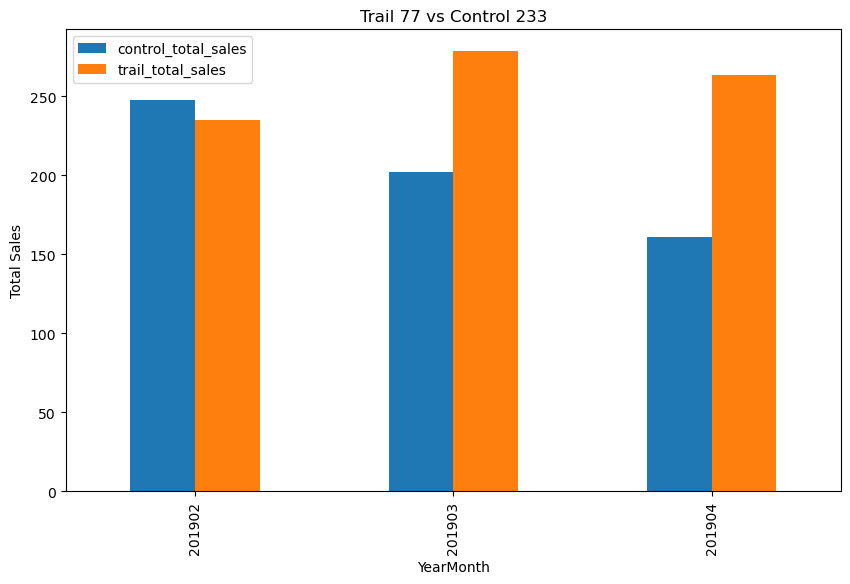

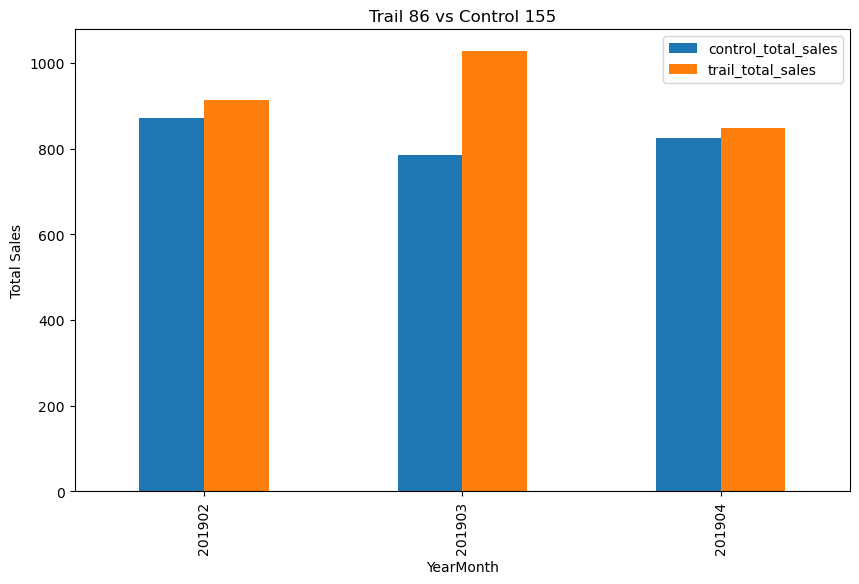

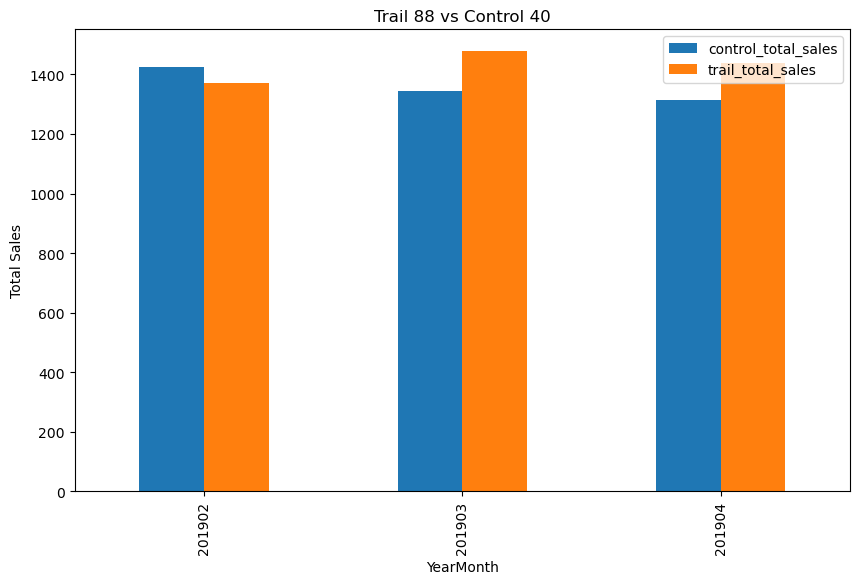

In [352]:
##viz 
#scaled_trial_vs_control


for trail, control in trail_control_dict.items():
    temp1 = scaled_trial_vs_control[(scaled_trial_vs_control['trail_period'] == 'trail') & 
                                   (scaled_trial_vs_control['STORE_NBR_control'] == control)][['YearMonth','Scale_Control_Sales']].rename(columns={"Scale_Control_Sales":"control_total_sales"})
    temp2 = scaled_trial_vs_control[(scaled_trial_vs_control['trail_period'] == 'trail') & 
                                   (scaled_trial_vs_control['STORE_NBR_trial'] == trail)][['YearMonth', 'totSales']].rename(columns={"totSales":"trail_total_sales"})
    
    combo = temp1.merge(temp2, on="YearMonth").set_index("YearMonth")
    #combo.plot.bar()
    
    combo.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Trail {trail} vs Control {control}')
    plt.xlabel('YearMonth')
    plt.ylabel('Total Sales')
    plt.show()


## customer number 

In [353]:
sales_ratio_233 = (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 77]['nCustomers'].sum())/ (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 233]['nCustomers'].sum())

sales_ratio_155 = (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 86]['nCustomers'].sum())/ (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 155]['nCustomers'].sum())

sales_ratio_40 = (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 88]['nCustomers'].sum())/ (preTrial_full_observ[preTrial_full_observ['STORE_NBR'] == 40]['nCustomers'].sum())

In [354]:
preTrial_full_observ

,STORE_NBR,YearMonth,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3160,272,201810,430.6,44,1.136364,1.980000,4.349495
3161,272,201811,376.2,41,1.097561,1.933333,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202
3163,272,201901,423.0,46,1.086957,1.920000,4.406250


In [355]:
Control_Store_nCust_Scale = full_observ[full_observ['STORE_NBR'].isin([233, 155, 40])]

def scale_sales(row):
    if row['STORE_NBR'] == 233:
        return row['nCustomers'] * sales_ratio_233
    
    elif row['STORE_NBR'] == 155:
        return row['nCustomers'] * sales_ratio_155
    
    elif row['STORE_NBR'] == 40:
        return row['nCustomers'] * sales_ratio_40

Control_Store_nCust_Scale['Scale_Control_nCust'] = Control_Store_nCust_Scale.apply(lambda x: scale_sales(x), axis = 1)

/var/folders/qc/zvz1knc173n7lpbcfzncj0_h0000gn/T/ipykernel_22328/2078784756.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Control_Store_nCust_Scale['Scale_Control_nCust'] = Control_Store_nCust_Scale.apply(lambda x: scale_sales(x), axis = 1)


In [356]:
trial_full_observ = full_observ[(full_observ['YearMonth']>=201902) & (full_observ['YearMonth']<=201904)]

trial_scale_control_observ = Control_Store_nCust_Scale[(Control_Store_nCust_Scale['YearMonth']<=201904) &
                                                      (Control_Store_nCust_Scale['YearMonth']>=201902)]
Pretrial_scale_control_observ = Control_Store_nCust_Scale[(Control_Store_nCust_Scale['YearMonth']<201902)]


In [357]:
percentage_diff = {}
trial_control_dict = {77:233, 86:155, 88:40}

trial_vs_control_trialperiod = pd.DataFrame()

for trail, control in trial_control_dict.items(): 
    c = trial_scale_control_observ[trial_scale_control_observ['STORE_NBR'] == control][['STORE_NBR', 'YearMonth', 'Scale_Control_nCust']]
    t = trial_full_observ[trial_full_observ['STORE_NBR'] == trail][['STORE_NBR', 'YearMonth','nCustomers']]
    percentage_diff[trail] = (t['nCustomers'].sum()-c['Scale_Control_nCust'].sum())/(c['Scale_Control_nCust'].sum())
    #a = c.merge(t, how = 'left', on ='YearMonth',suffixes=('_control', '_trial'))
    #a['percentage_diff'] = (a['totSales'].sum()-a['Scale_Control_Sales'].sum())
    #trial_vs_control_trialperiod = pd.concat([trial_vs_control_trialperiod,a])
print(percentage_diff) 

{77: 0.2311931243680484, 86: 0.11847014925373131, 88: 0.04824349012788614}


In [358]:
Control_Store_nCust_Scale.head(5)

,STORE_NBR,YearMonth,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Scale_Control_nCust
448,40,201807,1332.0,128,1.187500,2.013158,4.352941,130.204661
449,40,201808,1208.0,123,1.105691,1.970588,4.507463,125.118541
450,40,201809,1312.0,135,1.111111,2.000000,4.373333,137.325228
451,40,201810,1323.6,118,1.220339,2.027778,4.532877,120.032421
452,40,201811,1099.4,109,1.119266,2.000000,4.505738,110.877406


In [359]:
scaled_trial_vs_control = pd.DataFrame()
for trail, control in trial_control_dict.items(): 
    temp1 = Control_Store_nCust_Scale[Control_Store_nCust_Scale['STORE_NBR'] == control][['STORE_NBR', 'YearMonth', 'Scale_Control_nCust']]
    temp2 = full_observ[full_observ['STORE_NBR'] == trail][['STORE_NBR', 'YearMonth', 'nCustomers']]

    aa = temp1.merge(temp2, how = 'left', on = 'YearMonth', suffixes=('_control', '_trial'))
    scaled_trial_vs_control = pd.concat([scaled_trial_vs_control, aa])
    
    

In [360]:
scaled_trial_vs_control.head(5)

,STORE_NBR_control,YearMonth,Scale_Control_nCust,STORE_NBR_trial,nCustomers
0,233,201807,51.148688,77,51
1,233,201808,48.139942,77,47
2,233,201809,42.122449,77,42
3,233,201810,35.102041,77,37
4,233,201811,40.116618,77,41


In [361]:
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else :
        return "trail"

scaled_trial_vs_control['trail_period'] =  scaled_trial_vs_control['YearMonth'].apply(lambda cell:label_period(cell))

scaled_trial_vs_control['percentage_diff'] = (scaled_trial_vs_control['nCustomers']-scaled_trial_vs_control['Scale_Control_nCust'])/scaled_trial_vs_control['Scale_Control_nCust']

    

In [362]:
#1. check null-hypothesis-- 0 difference between control store's Pre-Trial and Trial period performance.
#trial_scale_control_observ 
for num in [233,155,40]:
    print("Control store:", num)
    print(ttest_ind(trial_scale_control_observ [trial_scale_control_observ ["STORE_NBR"] == num]["Scale_Control_nCust"],
                   Pretrial_scale_control_observ[Pretrial_scale_control_observ["STORE_NBR"] == num]["Scale_Control_nCust"],
                   equal_var=True), '\n')


Control store: 233
Ttest_indResult(statistic=-0.9175989187607333, pvalue=0.38565688358109473) 

Control store: 155
Ttest_indResult(statistic=-1.0517579047791799, pvalue=0.3236396669046278) 

Control store: 40
Ttest_indResult(statistic=-0.4797672699614256, pvalue=0.6442350441900941) 



In [368]:
#2. check control and trial stores are similar statistically
from scipy.stats import ttest_ind, t
for trail, control in trail_control_dict.items():
    print("Trial store:", trail, ", Control store:", control)
    print(ttest_ind(preTrail_full_observ[preTrail_full_observ["STORE_NBR"] == trail]["nCustomers"],
                   Pretrial_scale_control_observ[Pretrial_scale_control_observ["STORE_NBR"] == control]["Scale_Control_nCust"],
                   equal_var=True), '\n')
    
alpha = 0.05

print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(preTrail_full_observ[preTrail_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=0.10098667440627238, pvalue=0.9211019441774069) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=-0.20226318164219692, pvalue=0.8428419558583902) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=0.06834376624809368, pvalue=0.9465520075863941) 

Critical t-value for 95% confidence interval:
[-2.36462425  2.36462425]


In [369]:
#3.
from scipy.stats import ttest_ind, t
for trail, control in trail_control_dict.items():
    print("Trial store:", trail, ", Control store:", control)
    temp = scaled_trial_vs_control[(scaled_trial_vs_control["STORE_NBR_control"] == control) & 
                                   (scaled_trial_vs_control["trail_period"] == "pre")]
    std = temp['percentage_diff'].std()
    mean = temp['percentage_diff'].mean()
    #print(std)
    for date in scaled_trial_vs_control[scaled_trial_vs_control['trail_period'] == 'trail']['YearMonth'].unique():
        pdif = scaled_trial_vs_control[(scaled_trial_vs_control['YearMonth']== date) & 
                                            (scaled_trial_vs_control['STORE_NBR_trial'] == trail)]['percentage_diff']
        #print(pdif)
        print(date,":",(float(pdif)-mean)/std)
    print('\n') 
        
   
    #print(date, ":",(float(pdif)-mean)/std)
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df= 6)
print(conf_intv_95) 

Trial store: 77 , Control store: 233
201902 : -0.20772124481087564
201903 : 8.872608273685504
201904 : 20.374358997114253


Trial store: 86 , Control store: 155
201902 : 6.578056962547164
201903 : 11.64552143172691
201904 : 3.148383690686809


Trial store: 88 , Control store: 40
201902 : -0.37858542756250024
201903 : 1.249569811546516
201904 : 0.5696698785344623


Critical t-value for 95% confidence interval:
1.9431802803927816


There are 5 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

Feb, March and April trial months for trial store 86

In [366]:
scaled_trial_vs_control.head(5)

,STORE_NBR_control,YearMonth,Scale_Control_nCust,STORE_NBR_trial,nCustomers,trail_period,percentage_diff
0,233,201807,51.148688,77,51,pre,-0.002907
1,233,201808,48.139942,77,47,pre,-0.023680
2,233,201809,42.122449,77,42,pre,-0.002907
3,233,201810,35.102041,77,37,pre,0.054070
4,233,201811,40.116618,77,41,pre,0.022020


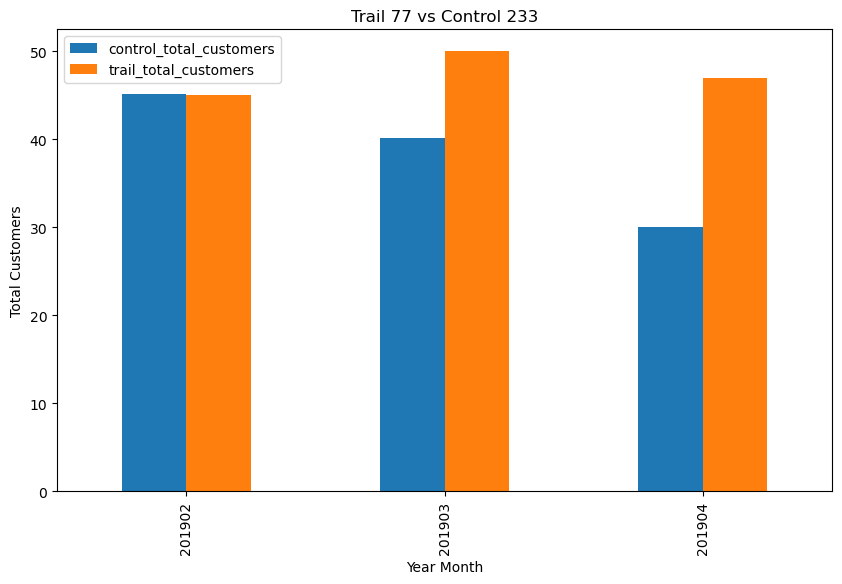

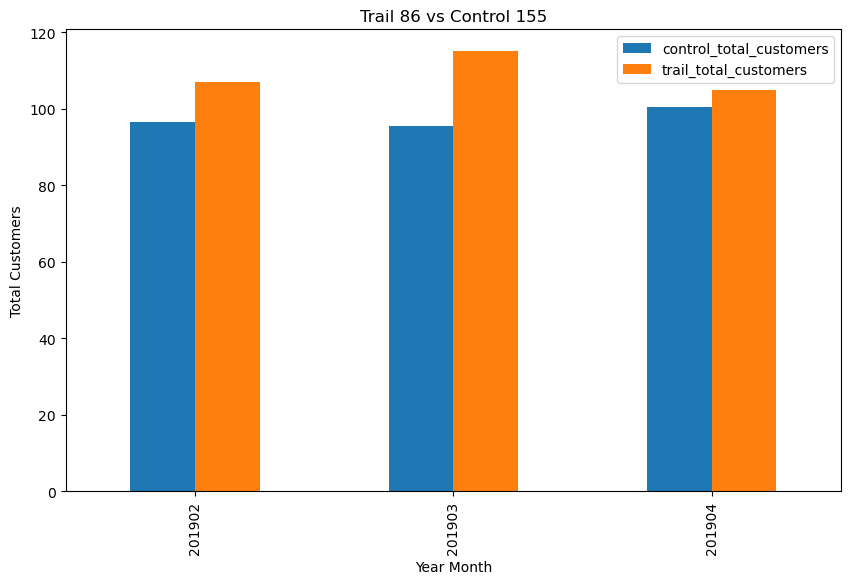

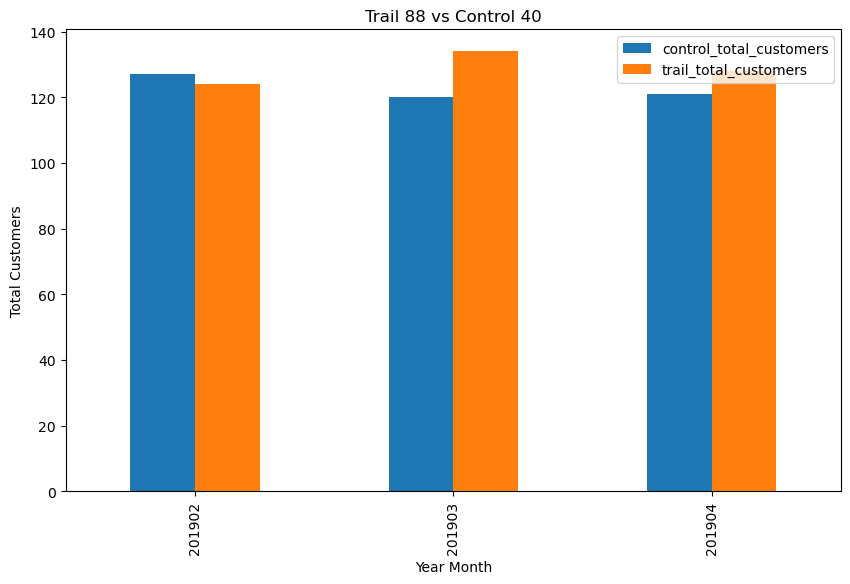

In [367]:
for trail, control in trail_control_dict.items():
    temp1 = scaled_trial_vs_control[(scaled_trial_vs_control['trail_period'] == 'trail') & 
                                   (scaled_trial_vs_control['STORE_NBR_control'] == control)][['YearMonth','Scale_Control_nCust']].rename(columns={"Scale_Control_nCust":"control_total_customers"})
    temp2 = scaled_trial_vs_control[(scaled_trial_vs_control['trail_period'] == 'trail') & 
                                   (scaled_trial_vs_control['STORE_NBR_trial'] == trail)][['YearMonth', 'nCustomers']].rename(columns={"nCustomers":"trail_total_customers"})
    
    combo = temp1.merge(temp2, on="YearMonth").set_index("YearMonth")
    #combo.plot.bar()
    
    combo.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Trail {trail} vs Control {control}')
    plt.xlabel('Year Month')
    plt.ylabel('Total Customers')
    plt.show()